# Train GPPL

In [2]:
import os
import sys
if os.getcwd().endswith("train"):
    os.chdir("..\\..\\")
sys.path.append(os.path.join(os.getcwd(), "gppl_src", "python", "models"))

In [3]:
from preprocessing.data_preprocessing import load_and_preprocess_data, preprocess_for_crowdGPPL, CATEGORIES
from gppl_src.python.models.gp_pref_learning import *
from gppl_src.python.models.gp_classifier_vb import compute_median_lengthscales
from gppl_src.python.models.collab_pref_learning_svi import CollabPrefLearningSVI
from sklearn.model_selection import train_test_split
from utils.utils import save_model, load_model
import matplotlib.pyplot as plt
from tqdm import tqdm

### load and preprocess datasets

In [4]:
output = load_and_preprocess_data()

D:\Users\Daniel\anaconda3\envs\dldh\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [5]:
(preprocessed_dataset, preprocessed_full_dataset), (preprocessed_dataset_test, preprocessed_full_dataset_test) = output

In [17]:
(unique_poems, preferences_train, a1_poem_idx_train, a2_poem_idx_train, poem_embed) = preprocessed_dataset
(_, preferences_test, a1_poem_idx_test, a2_poem_idx_test, _) = preprocessed_dataset_test

In [18]:
print(f"size train set: {len(preferences_train)} \nsize test set: {len(preferences_test)}")

size train set: 3429 
size test set: 381


### Train GPPL

In [9]:
CATEGORIES:list   = ["coherent", "grammatical", "melodious", "moved", "real", "rhyming", "readable", "comprehensible", "intense", "liking"]	

##### Trained on Feature Liking

In [49]:
gppl_model = GPPrefLearning(ninput_features=poem_embed.shape[1], shape_s0=2, rate_s0=200, ls_initial=compute_median_lengthscales(poem_embed), verbose=True)

In [50]:
gppl_model.fit(items1_coords=a1_poem_idx_train, items2_coords=a2_poem_idx_train, item_features=poem_embed, preferences=preferences_train[:, -1])

D:\Users\Daniel\anaconda3\envs\dldh\lib\site-packages\sklearn\cluster\_kmeans.py:1045: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [52]:
pred_liking = gppl_model.predict(poem_embed, a1_poem_idx_train, a2_poem_idx_train)[0]
pred_label = np.rint(pred_liking.flatten())
print("Train Accuracy on consolidated batches - feature linking: {}".format(np.sum(pred_label == preferences_train[:, -1]) / len(pred_label)))

Train Accuracy on consolidated batches - feature linking: 0.6456692913385826


In [53]:
pred_liking = gppl_model.predict(poem_embed, a1_poem_idx_test, a2_poem_idx_test)[0]
pred_label = np.rint(pred_liking.flatten())
print("Test Accuracy on consolidated batches - feature linking: {}".format(np.sum(pred_label == preferences_test[:, -1]) / len(pred_label)))

Test Accuracy on consolidated batches - feature linking: 0.5380577427821522


In [33]:
del gppl_model

#### Training on stacked Features

In [22]:
stacked_preferences_train = np.ravel(preferences_train, order="F")
stacked_preferences_test = np.ravel(preferences_test, order="F")
stacked_a1_poem_idx_train = np.repeat(a1_poem_idx_train, len(CATEGORIES))
stacked_a2_poem_idx_train = np.repeat(a2_poem_idx_train, len(CATEGORIES))
stacked_a1_poem_idx_test = np.repeat(a1_poem_idx_test, len(CATEGORIES))
stacked_a2_poem_idx_test = np.repeat(a2_poem_idx_test, len(CATEGORIES))

In [20]:
gppl_model_stacked = GPPrefLearning(ninput_features=poem_embed.shape[1], shape_s0=2, rate_s0=200, ls_initial=compute_median_lengthscales(poem_embed), verbose=True)

In [26]:
gppl_model_stacked.fit(items1_coords=stacked_a1_poem_idx_train, items2_coords=stacked_a2_poem_idx_train, item_features=poem_embed, preferences=stacked_preferences_train)

In [33]:
pred_stacked = gppl_model_stacked.predict(poem_embed, stacked_a1_poem_idx_train, stacked_a2_poem_idx_train)[0]
pred_label = np.rint(pred_stacked.flatten())
print("Train Accuracy on stacked features: {}".format(np.sum(pred_label == stacked_preferences_train) / len(pred_label)))

Train Accuracy on stacked features: 0.5531641878098571


In [31]:
pred_stacked = gppl_model_stacked.predict(poem_embed, stacked_a1_poem_idx_test, stacked_a2_poem_idx_test)[0]
pred_label = np.rint(pred_stacked.flatten())
print("Test Accuracy on stacked features: {}".format(np.sum(pred_label == stacked_preferences_test) / len(pred_label)))

Test Accuracy on stacked features: 0.5044619422572179


#### Training on Full Dataset

In [6]:
(unique_poems, preferences_train, a1_poem_idx_train, a2_poem_idx_train, poem_embed, workerID_train) = preprocessed_full_dataset
(_, preferences_test, a1_poem_idx_test, a2_poem_idx_test, _, workerID_test) = preprocessed_full_dataset_test

In [11]:
gppl_model_full = GPPrefLearning(ninput_features=poem_embed.shape[1], shape_s0=2, rate_s0=200, ls_initial=compute_median_lengthscales(poem_embed), verbose=True)

In [12]:
gppl_model_full.fit(items1_coords=a1_poem_idx_train, items2_coords=a2_poem_idx_train, item_features=poem_embed, preferences=preferences_train[:, -1])

D:\Users\Daniel\anaconda3\envs\dldh\lib\site-packages\sklearn\cluster\_kmeans.py:1045: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [13]:
pred_liking = gppl_model_full.predict(poem_embed, a1_poem_idx_train, a2_poem_idx_train)[0]
pred_label  = np.rint(pred_liking.flatten())
print("Train Accuracy on full batches: {}".format(np.sum(pred_label == preferences_train[:, -1]) / len(pred_label)))

Train Accuracy on full batches: 0.6648709951800397


In [14]:
pred_liking = gppl_model_full.predict(poem_embed, a1_poem_idx_test, a2_poem_idx_test)[0]
pred_label  = np.rint(pred_liking.flatten())
print("Test Accuracy on full batches: {}".format(np.sum(pred_label == preferences_test[:, -1]) / len(pred_label)))

Test Accuracy on full batches: 0.5249343832020997


### Crowd GPPL

#### CrowdGPPL on feature liking

##### Consolidated Batches

In [7]:
(unique_poems, preferences_train, a1_poem_idx_train, a2_poem_idx_train, poem_embed) = preprocessed_dataset
(_, preferences_test, a1_poem_idx_test, a2_poem_idx_test, _) = preprocessed_dataset_test

In [13]:
workerID_train = np.resize([1,2,3], len(preferences_train))
workerID_test = np.resize([1,2,3], len(preferences_test))

In [14]:
crowdGPPL_model = CollabPrefLearningSVI(nitem_features=poem_embed.shape[1], nperson_features=workerID_train.shape[0], shape_s0=2, rate_s0=200, use_lb=True, use_common_mean_t=True, ls=None, verbose=True)

In [15]:
crowdGPPL_model.fit(personIDs=workerID_train, items_1_coords=a1_poem_idx_train, items_2_coords=a2_poem_idx_train, item_features=poem_embed, preferences=preferences_train[:, -1], use_median_ls=True)

D:\Users\Daniel\anaconda3\envs\dldh\lib\site-packages\sklearn\cluster\_kmeans.py:1045: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [16]:
pred_liking = crowdGPPL_model.predict_common(poem_embed, a1_poem_idx_train, a2_poem_idx_train)
pred_label  = np.rint(pred_liking.flatten())
print("CrowdGPPL: Train Accuracy on consolidated batches: {}".format(np.sum(pred_label == preferences_train[:, -1]) / len(pred_label)))

CrowdGPPL: Train Accuracy on consolidated batches: 0.6564596092155147


In [17]:
pred_liking = crowdGPPL_model.predict_common(poem_embed, a1_poem_idx_test, a2_poem_idx_test)
pred_label  = np.rint(pred_liking.flatten())
print("CrowdGPPL: Test Accuracy on consolidated batches: {}".format(np.sum(pred_label == preferences_test[:, -1]) / len(pred_label)))

CrowdGPPL: Test Accuracy on consolidated batches: 0.5196850393700787


##### Full Dataset

In [67]:
(unique_poems, preferences_train, a1_poem_idx_train, a2_poem_idx_train, poem_embed, workerID_train) = preprocessed_full_dataset
(_, preferences_test, a1_poem_idx_test, a2_poem_idx_test, _, workerID_test) = preprocessed_full_dataset_test

In [38]:
crowdGPPL_model = CollabPrefLearningSVI(nitem_features=poem_embed.shape[1], nperson_features=workerID_train.shape[0], shape_s0=2, rate_s0=200, use_lb=True, use_common_mean_t=True, ls=None, verbose=True)

In [39]:
crowdGPPL_model.fit(personIDs=workerID_train, items_1_coords=a1_poem_idx_train, items_2_coords=a2_poem_idx_train, item_features=poem_embed, preferences=preferences_train[:, -1], use_median_ls=True)

D:\Users\Daniel\anaconda3\envs\dldh\lib\site-packages\sklearn\cluster\_kmeans.py:1045: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [48]:
pred_liking = crowdGPPL_model.predict_common(poem_embed, a1_poem_idx_train, a2_poem_idx_train)
pred_label  = np.rint(pred_liking.flatten())
print("CrowdGPPL: Train Accuracy on full batches: {}".format(np.sum(pred_label == preferences_train[:, -1]) / len(pred_label)))

CrowdGPPL: Train Accuracy on full batches: 0.5574142330592572


In [68]:
pred_liking = crowdGPPL_model.predict_common(poem_embed, a1_poem_idx_test, a2_poem_idx_test)
pred_label  = np.rint(pred_liking.flatten())
print("CrowdGPPL: Test Accuracy on full batches: {}".format(np.sum(pred_label == preferences_test[:, -1]) / len(pred_label)))

CrowdGPPL: Test Accuracy on full batches: 0.4896755162241888


In [ ]:
save_model(crowdGPPL_model, "src/model/crowdGPPL")

In [ ]:
crowdGPPL_model = load_model("src/model/crowdGPPL")

#### On Stacked Features

In [83]:
stacked_preferences_train = np.ravel(preferences_train, order="F")
stacked_preferences_test = np.ravel(preferences_test, order="F")

# not every preference is given -> remove NaN samples
train_idxs = ~np.isnan(stacked_preferences_train)
test_idxs = ~np.isnan(stacked_preferences_test)

In [84]:
stacked_preferences_train = stacked_preferences_train[train_idxs]
stacked_preferences_test = stacked_preferences_test[test_idxs]
stacked_a1_poem_idx_train = np.repeat(a1_poem_idx_train, len(CATEGORIES))[train_idxs]
stacked_a2_poem_idx_train = np.repeat(a2_poem_idx_train, len(CATEGORIES))[train_idxs]
stacked_a1_poem_idx_test = np.repeat(a1_poem_idx_test, len(CATEGORIES))[test_idxs]
stacked_a2_poem_idx_test = np.repeat(a2_poem_idx_test, len(CATEGORIES))[test_idxs]
stacked_WorkerID_train = np.repeat(workerID_train, len(CATEGORIES))[train_idxs]
stacked_WorkerID_test = np.repeat(workerID_test, len(CATEGORIES))[test_idxs]

In [85]:
crowdGPPL_model_stacked = CollabPrefLearningSVI(nitem_features=poem_embed.shape[1], nperson_features=workerID_train.shape[0], shape_s0=2, rate_s0=200, use_lb=True, use_common_mean_t=True, ls=None, verbose=True)

In [86]:
crowdGPPL_model_stacked.fit(personIDs=stacked_WorkerID_train, items_1_coords=stacked_a1_poem_idx_train, items_2_coords=stacked_a2_poem_idx_train, item_features=poem_embed, preferences=stacked_preferences_train, use_median_ls=True)

D:\Users\Daniel\anaconda3\envs\dldh\lib\site-packages\sklearn\cluster\_kmeans.py:1045: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [88]:
pred_liking = crowdGPPL_model_stacked.predict_common(poem_embed, stacked_a1_poem_idx_train, stacked_a2_poem_idx_train)
pred_label  = np.rint(pred_liking.flatten())
print("CrowdGPPL: Train Accuracy on full batches - stacked categories: {}".format(np.sum(pred_label == stacked_preferences_train) / len(pred_label)))

CrowdGPPL: Train Accuracy on full batches - stacked categories: 0.5213252924507739


In [90]:
pred_liking = crowdGPPL_model_stacked.predict_common(poem_embed, stacked_a1_poem_idx_test, stacked_a2_poem_idx_test)
pred_label  = np.rint(pred_liking.flatten())
print("CrowdGPPL: Test Accuracy on full batches - stacked categories: {}".format(np.sum(pred_label == stacked_preferences_test) / len(pred_label)))

CrowdGPPL: Test Accuracy on full batches - stacked categories: 0.48881789137380194


#### Each category independent

In [91]:
(unique_poems, preferences_train, a1_poem_idx_train, a2_poem_idx_train, poem_embed) = preprocessed_dataset
(_, preferences_test, a1_poem_idx_test, a2_poem_idx_test, _) = preprocessed_dataset_test

In [92]:
preferences_train, a1_poem_idx_train, a2_poem_idx_train, workerID_train = preprocess_for_crowdGPPL(preferences_train, a1_poem_idx_train, a2_poem_idx_train)
preferences_test, a1_poem_idx_test, a2_poem_idx_test, workerID_test = preprocess_for_crowdGPPL(preferences_test, a1_poem_idx_test, a2_poem_idx_test)

In [93]:
cat_crowdGPPL_model = CollabPrefLearningSVI(nitem_features=poem_embed.shape[1], nperson_features=workerID_train.shape[0], shape_s0=2, rate_s0=200, use_lb=True, use_common_mean_t=True, ls=None, verbose=True)

In [95]:
cat_crowdGPPL_model.fit(personIDs=workerID_train, items_1_coords=a1_poem_idx_train, items_2_coords=a2_poem_idx_train, item_features=poem_embed, preferences=preferences_train, use_median_ls=True)

D:\Users\Daniel\anaconda3\envs\dldh\lib\site-packages\sklearn\cluster\_kmeans.py:1045: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [98]:
pred_liking = cat_crowdGPPL_model.predict(workerID_train ,a1_poem_idx_train, a2_poem_idx_train)
pred_label = np.rint(pred_liking.flatten())
print(f"CrowdGPPL: Train Accuracy - all: {np.sum(pred_label == preferences_train) / len(pred_liking)}")

CrowdGPPL: Train Accuracy - all: 0.636920384951881


In [103]:
pred_liking = cat_crowdGPPL_model.predict(workerID_test, a1_poem_idx_test, a2_poem_idx_test)
pred_label = np.rint(pred_liking.flatten())
print(f"CrowdGPPL: Test Accuracy - all: {np.sum(pred_label == preferences_test) / len(pred_liking)}")

CrowdGPPL: Test Accuracy - all: 0.4937007874015748


In [101]:
pred_liking = cat_crowdGPPL_model.predict(workerID_train[-1] ,a1_poem_idx_train, a2_poem_idx_train)
pred_label = np.rint(pred_liking.flatten())
print(f"CrowdGPPL: Train Accuracy - liking: {np.sum(pred_label == preferences_train[-len(pred_label):]) / len(pred_liking)}")

CrowdGPPL: Train Accuracy - liking: 0.5732866724992709


In [104]:
pred_liking = cat_crowdGPPL_model.predict(workerID_test[-1] ,a1_poem_idx_test, a2_poem_idx_test)
pred_label = np.rint(pred_liking.flatten())
print(f"CrowdGPPL: Test Accuracy - liking: {np.sum(pred_label == preferences_test[-len(pred_label):]) / len(pred_liking)}")

CrowdGPPL: Test Accuracy - liking: 0.5123359580052493


### Plot models

In [ ]:
CATEGORIES_to_idx = dict.fromkeys(range(0, len(CATEGORIES)), CATEGORIES)
gppl_models = []
for idx in tqdm(range(len(CATEGORIES))):
    gppl_model = GPPrefLearning(ninput_features=poem_embed.shape[1], shape_s0=2, rate_s0=200, ls_initial=compute_median_lengthscales(poem_embed), verbose=True)
    gppl_model.fit(items1_coords=a1_poem_idx_train, items2_coords=a2_poem_idx_train, item_features=poem_embed, preferences=preferences_train[:, idx])
    gppl_models.append(gppl_model)

In [ ]:
save_model(cat_crowdGPPL_model, "src/model/crowdGPPL")

array([[0.4204461 ],
       [0.4204461 ],
       [0.4204461 ],
       ...,
       [0.44554376],
       [0.44554376],
       [0.44554376]])

In [ ]:
predictions = {cat : [gppl.predict(poem_embed, a1_poem_idx_train, a2_poem_idx_train)[0], cat_crowdGPPL_model.predict(idx, a1_poem_idx_train, a2_poem_idx_train)] for idx, (cat, gppl) in enumerate(zip(CATEGORIES, gppl_models))}

In [ ]:
accuracies = {cat: [np.sum(np.rint(p.flatten()) == preferences_train[:, idx]) / p.shape[0] for p in pred] for idx, (cat, pred) in enumerate(predictions.items())} 

In [ ]:
accuracies

{'coherent': [0.6447886584405356, 0.5699658703071673],
 'grammatical': [0.6461013389341035, 0.5641900761354687],
 'melodious': [0.6542399579942242, 0.5718036229981622],
 'moved': [0.6576529272775007, 0.5715410868994487],
 'real': [0.6694670517196114, 0.5778419532685745],
 'rhyming': [0.6552901023890785, 0.5691782620110265],
 'readable': [0.6518771331058021, 0.5849304279338409],
 'comprehensible': [0.6665791546337622, 0.5589393541611971],
 'intense': [0.6398004725649776, 0.55473877658178],
 'liking': [0.6471514833289578, 0.5712785508007351]}

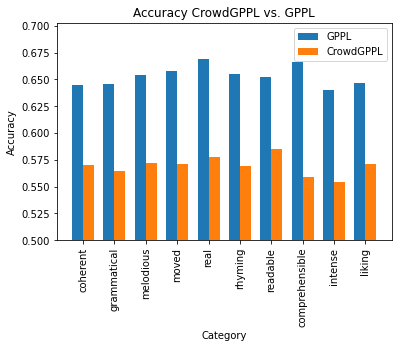

In [ ]:
index = np.arange(len(accuracies))
bar_width = 0.35

gppl_acc, crowdGPPL_acc = zip(*accuracies.values())

fig, ax = plt.subplots()
plt.xticks(rotation=90)
summer = ax.bar(index, gppl_acc, bar_width,
                label="GPPL")

winter = ax.bar(index+bar_width, crowdGPPL_acc,
                 bar_width, label="CrowdGPPL")

ax.set_xlabel('Category')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy CrowdGPPL vs. GPPL')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(accuracies.keys())
ax.set_ylim(bottom=0.5)
ax.legend()

plt.show()